In [ ]:
!nvidia-smi

Sun Nov 19 03:17:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   70C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# prompt: CPUのコア数をしらべて
import os
os.cpu_count()

2

In [ ]:
class Config:
    name = "exp024" # 実験のたびにコピーしてここの名前を変えて実行するとoutputが別のファイルに保存される

    # Colab Env
    upload_from_colab = False
    api_path = "/content/drive/MyDrive/kaggle/kaggle.json"
    drive_path = "/content/drive/MyDrive/kaggle/ucbo"

DEBUG = False


In [ ]:
import os
import json
import warnings
import shutil
import logging
import joblib
import random
import datetime
import sys


In [ ]:
COLAB = "google.colab" in sys.modules
!pip install --upgrade --force-reinstall --no-deps kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110683 sha256=0125186d080f26d28e6711ebb0d9404e5803511696b4bad4b9f90197e87d0452
  Stored in directory: /root/.cache/pip/wheels/43/4b/fb/736478af5e8004810081a06259f9aa2f7c3329fc5d03c2c412
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [ ]:
if COLAB:
    print("This environment is Google Colab")

    # mount
    from google.colab import drive
    if not os.path.isdir("/content/drive"):
        drive.mount('/content/drive')


    # use kaggle api (need kaggle token)
    f = open(Config.api_path, 'r')
    json_data = json.load(f)
    os.environ["KAGGLE_USERNAME"] = json_data["username"]
    os.environ["KAGGLE_KEY"] = json_data["key"]

    # set dirs
    DRIVE = Config.drive_path
    EXP = Config.name
    INPUT = os.path.join(DRIVE, "Input")
    OUTPUT = os.path.join(DRIVE, "Output")
    SCRIPT = os.path.join(DRIVE, "Script")
    OUTPUT_EXP = os.path.join(OUTPUT, EXP)

    # make dirs
    for d in [INPUT, SCRIPT, OUTPUT, OUTPUT_EXP]:
        os.makedirs(d, exist_ok=True)

    # if not os.path.isfile(os.path.join(INPUT, "train.csv")):
    #     # load dataset
    #     ! kaggle competitions download -c UBC-OCEAN -p $INPUT
    #     unzip_file = os.path.join(INPUT, 'UBC-OCEAN.zip')
    #     ! unzip $unzip_file -d $INPUT



This environment is Google Colab
Mounted at /content/drive


In [ ]:
%%time
if not DEBUG:
    # tmp fileに直接ダウンロードする
    TMP = '/content/tmp'
    INPUT = '/content/tmp'
    !mkdir $TMP
    files = [
        'tyabanoamami/ucbo-colab-dataset', 'hmendonca/efficientnet-pytorch',
            #  'pjmathematician/ucbo-tiles-256-1', #'tyabanoamami/ucbo-clean-images',
            #  'pjmathematician/ucbo-tiles-256-2', 'pjmathematician/ucbo-tiles-256-3',
            #  'pjmathematician/ucbo-tiles-256-4', 'pjmathematician/ucbo-tiles-256-5',
        'jirkaborovec/tiles-of-cancer-2048px-scale-0-25'
            ]
    for f in files:
        !kaggle datasets download -d $f -p $TMP
        t = f.split('/')[1]
        unzip_file = os.path.join(TMP, f'{t}.zip')
        unzip_file_ = TMP + '/' + t
        INPUT_ = INPUT + '/' + t
        ! unzip $unzip_file -d $unzip_file_
        # !mv $unzip_file_ $INPUT_
        !rm -rf $unzip_file

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: /content/tmp/tiles-of-cancer-2048px-scale-0-25/7204/000210_3-17.png  
  inflating: /content/tmp/tiles-of-cancer-2048px-scale-0-25/7204/000211_4-17.png  
  inflating: /content/tmp/tiles-of-cancer-2048px-scale-0-25/7329/000001_2-1.png  
  inflating: /content/tmp/tiles-of-cancer-2048px-scale-0-25/7329/000002_3-1.png  
  inflating: /content/tmp/tiles-of-cancer-2048px-scale-0-25/7329/000003_4-1.png  
  inflating: /content/tmp/tiles-of-cancer-2048px-scale-0-25/7329/000004_5-1.png  
  inflating: /content/tmp/tiles-of-cancer-2048px-scale-0-25/7329/000005_6-1.png  
  inflating: /content/tmp/tiles-of-cancer-2048px-scale-0-25/7329/000006_7-1.png  
  inflating: /content/tmp/tiles-of-cancer-2048px-scale-0-25/7329/000014_2-2.png  
  inflating: /content/tmp/tiles-of-cancer-2048px-scale-0-25/7329/000015_3-2.png  
  inflating: /content/tmp/tiles-of-cancer-2048px-scale-0-25/7329/000016_4-2.png  
  inflating: /content/tmp/tiles-of-cancer-2048px-scale-0-25/7329

# Library

In [ ]:
!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
!pip install timm

  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-lxuypvyc
  Running command git clone --filter=blob:none --quiet https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-lxuypvyc
  Resolved https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to commit 6b5e8953a80aef5b324104dc0c2e9b8c34d622bd
  Preparing metadata (setup.py) ... done
  Created wheel for warmup-scheduler: filename=warmup_scheduler-0.3.2-py3-none-any.whl size=3865 sha256=bc90421552c9f0878681e388df153d36a169f3a0380086ac992fbee7a4664484
  Stored in directory: /tmp/pip-ephem-wheel-cache-lj7ytsn_/wheels/49/78/e6/9168d5844935482a171c7880a0626fa1c6c412b55666635f59
Successfully built warmup-scheduler
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.6 MB/s eta 0:00:00


In [ ]:
import os
import sys
sys.path = [
    os.path.join(INPUT, 'efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master'),
] + sys.path

In [ ]:
import time
import skimage.io
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm.notebook import tqdm
from sklearn.metrics import balanced_accuracy_score
import timm


# Config

In [ ]:
data_dir = os.path.join(INPUT, 'tiles-of-cancer-2048px-scale-0-25')
df_train = pd.read_csv(os.path.join(data_dir, 'train.csv'))
image_folder = os.path.join(data_dir, 'train_images')
labels = ['CC', 'EC', 'HGSC', 'LGSC', 'MC', 'Other'] #df_train['label'].unique().tolist() + ['Other']
l2n = {v: k for k, v in enumerate(labels)}
n2l = {k: v for k, v in enumerate(labels)}

kernel_type = Config.name

enet_type = 'efficientnet_b0'
fold = 0
tile_size = 512
image_size = 512
n_tiles = 4 if DEBUG else 9
batch_size = 2
num_workers = os.cpu_count()
out_dim = 6
init_lr = 3e-4
warmup_factor = 10

warmup_epo = 1
n_epochs = 1 if DEBUG else 20
df_train = df_train.sample(100).reset_index(drop=True) if DEBUG else df_train

device = torch.device('cuda')

print(image_folder)

import random
def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_torch()

/content/tmp/tiles-of-cancer-2048px-scale-0-25/train_images


# Create Folds

In [ ]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)
df_train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['label'])):
    df_train.loc[valid_idx, 'fold'] = i
# df_train.head()

In [ ]:
def get_image_path(image_id:int):
    path = os.path.join(INPUT, 'tiles-of-cancer-2048px-scale-0-25')
    return os.path.join(path, str(image_id))

df_train['tile_path'] = df_train['image_id'].apply(lambda x: get_image_path(x))

# df_train['total_tiles'] = df_train['tile_path'].apply(lambda x: len(os.listdir(x)))
# df_train.head()

# train['clean_tiles'] = train['image_id'].apply(lambda x: len(d[x]))/train['total_tiles']
# train.head()

# Model

In [ ]:
# prompt: class enetv2(nn.Module):     def __init__(self, backbone, out_dim):         super(enetv2, self).__init__()         self.enet = enet.EfficientNet.from_name(backbone)         self.enet.load_state_dict(torch.load(pretrained_model[backbone]))          self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)         self.enet._fc = nn.Identity()      def extract(self, x):         return self.enet(x)      def forward(self, x):         x = self.extract(x)         x = self.myfc(x)         return xこのモデルをtimmを使って書き直してください

class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = timm.create_model(backbone, pretrained=True)
        self.myfc = nn.Linear(self.enet.classifier.in_features, out_dim)
        self.enet.classifier = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x


In [ ]:
# model = enetv2('efficientnet_b0', 6)
# model = timm.create_model('efficientnet_b0', pretrained=True)
# model.__dict__['default_cfg']

# Dataset

In [ ]:
# def get_tiles(paths):
#     ret = []
#     for path in paths:
#         # PNGファイルを読み込み
#         image = PIL.Image.open(path)

#         # Pillow ImageオブジェクトをNumPy配列に変換
#         image_array = np.array(image)
#         ret.append(image_array)
#     return ret

def check_bw(image):
    black = (image.mean(-1)/256 == 0).sum()/256**2
    white = (image.mean(-1)/256 > 0.92).sum()/256**2
    return black, white

def get_tiles(paths, img_id):
    ret = []
    for path in paths:
        # PNGファイルを読み込み
        image = PIL.Image.open(path)
        image = np.array(image)
        black, white = check_bw(image)
        if ((black < 0.25) and (white < 0.4) and (black+white < 0.6)) or (df_train.loc[df_train.image_id==img_id, 'is_tma'].values[0]):
            ret.append(image)
    return ret


class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 n_tiles=n_tiles,
                 tile_mode=0,
                 rand=False,
                 transform=None,
                ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode
        self.rand = rand
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id

        files = os.listdir(row.tile_path)
        tiles = [row.tile_path + f'/{e}' for e in files]
        # tiles = good_images[img_id]
        tiles = get_tiles(tiles, img_id)

        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))

        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w

                if len(tiles) > idxes[i]:
                    this_img = tiles[idxes[i]]
                else:
                    this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img

        # if self.transform is not None:
        #     images = self.transform(image=images)['image']
        images = images.astype(np.float32)
        # images /= 255
        images = images.transpose(2, 0, 1)

        label = np.zeros(out_dim).astype(np.float32)
        label[l2n[row.label]] = 1.
        return torch.tensor(images), torch.tensor(label)


# Augmentations

In [ ]:
transforms_train = albumentations.Compose([
    albumentations.Normalize(
                mean=[0.485, 0.456, 0.406], # 上のimages /= 255に注意
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0),
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
])
transforms_val = albumentations.Compose([
    albumentations.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
                p=1.0),
    ])

# efficientnetb0
# 'mean': (0.485, 0.456, 0.406),
#  'std': (0.229, 0.224, 0.225),

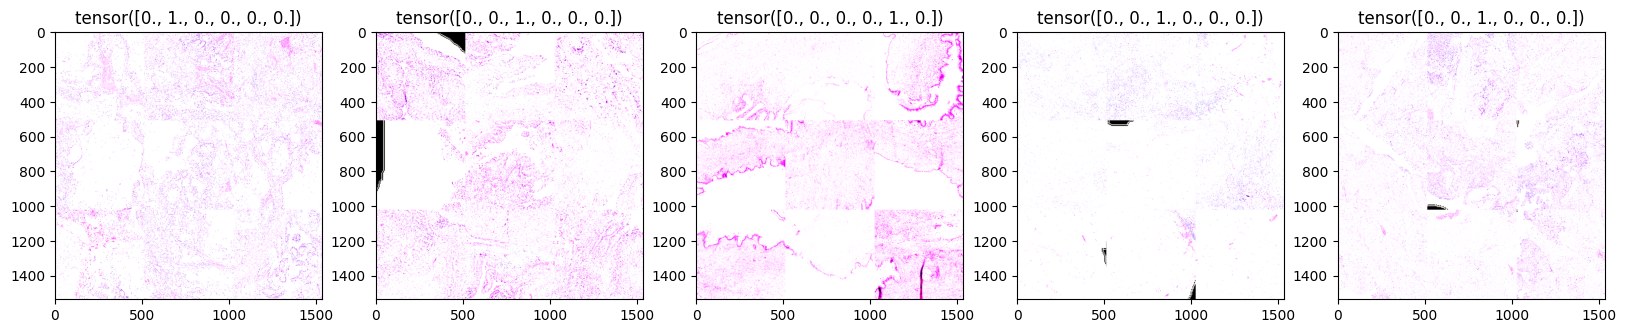

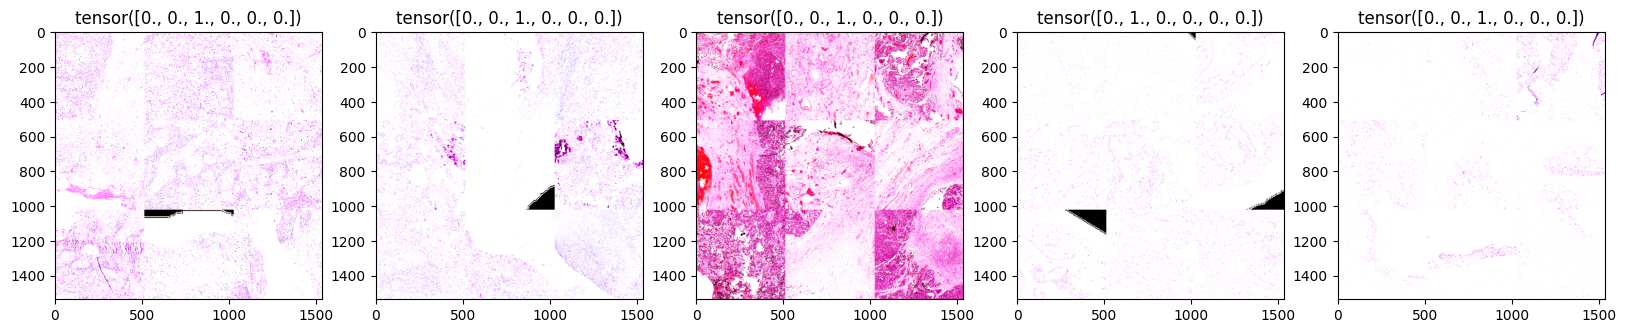

In [ ]:
dataset_show = PANDADataset(df_train, image_size, n_tiles, 0, False, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        img = np.clip(img, 0, 1)
        axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(label)

# Loss

In [ ]:
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()

# Train and Val

In [ ]:
def train_epoch(loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:

        data, target = data.to(device), target.to(device)
        loss_func = criterion
        optimizer.zero_grad()
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)

            loss = criterion(logits, target)

            pred = logits.sigmoid().detach()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target)

            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
#     acc = (PREDS == TARGETS).mean() * 100.
    comp_metric = balanced_accuracy_score(TARGETS.argmax(1), PREDS.argmax(1))
    print(comp_metric)

#     qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
#     qwk_k = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'karolinska'], df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, weights='quadratic')
#     qwk_r = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'radboud'], df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, weights='quadratic')
#     print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)

    if get_output:
        return LOGITS
    else:
        return val_loss, comp_metric, PREDS



# Create Dataloader & Model & Optimizer

In [ ]:
train_idx = np.where((df_train['fold'] != fold))[0]
valid_idx = np.where((df_train['fold'] == fold))[0]

df_this  = df_train.loc[train_idx]
df_valid = df_train.loc[valid_idx]

dataset_train = PANDADataset(df_this , image_size, n_tiles, transform=transforms_train)
dataset_valid = PANDADataset(df_valid, image_size, n_tiles, transform=transforms_val)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=num_workers)

model = enetv2(enet_type, out_dim=out_dim)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
scheduler = GradualWarmupScheduler(optimizer, multiplier=warmup_factor, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

print(len(dataset_train), len(dataset_valid))

model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

430 108


# Run Training

In [ ]:
%%time
comp_metric_max = 0.
best_file = os.path.join(OUTPUT_EXP, f'{kernel_type}_best_fold{fold}.pth')
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    scheduler.step(epoch-1)

    train_loss = train_epoch(train_loader, optimizer)
    val_loss, comp_metric, oof_preds = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, balanced accuracy: {(comp_metric):.5f}'
    print(content)
    with open(os.path.join(OUTPUT_EXP, f'log_{kernel_type}.txt'), 'a') as appender:
        appender.write(content + '\n')

    if comp_metric > comp_metric_max:
        print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(comp_metric_max, comp_metric))
        torch.save(model.state_dict(), best_file)
        np.save(os.path.join(OUTPUT_EXP, f'oof_preds_best_fold{fold}.npy'), oof_preds)
        comp_metric_max = comp_metric

torch.save(model.state_dict(), os.path.join(OUTPUT_EXP, f'{kernel_type}_final_fold{fold}.pth'))
np.save(os.path.join(OUTPUT_EXP, f'oof_preds_final_fold{fold}.npy'), oof_preds)
print(f'comp metric max {comp_metric_max}')

Sun Nov 19 03:35:14 2023 Epoch: 1


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://githu

  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

0.3588888888888889
Sun Nov 19 04:19:43 2023 Epoch 1, lr: 0.0000300, train loss: 0.49881, val loss: 0.40927, balanced accuracy: 0.35889
score2 (0.000000 --> 0.358889).  Saving model ...
Sun Nov 19 04:19:43 2023 Epoch: 2


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

0.5406666666666666
Sun Nov 19 05:03:46 2023 Epoch 2, lr: 0.0003000, train loss: 0.35137, val loss: 0.30556, balanced accuracy: 0.54067
score2 (0.358889 --> 0.540667).  Saving model ...
Sun Nov 19 05:03:47 2023 Epoch: 3


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

0.556
Sun Nov 19 05:48:39 2023 Epoch 3, lr: 0.0000300, train loss: 0.30710, val loss: 0.26995, balanced accuracy: 0.55600
score2 (0.540667 --> 0.556000).  Saving model ...
Sun Nov 19 05:48:39 2023 Epoch: 4


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

0.49288888888888893
Sun Nov 19 06:32:55 2023 Epoch 4, lr: 0.0002919, train loss: 0.31835, val loss: 0.32891, balanced accuracy: 0.49289
Sun Nov 19 06:32:55 2023 Epoch: 5


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

0.6688888888888889
Sun Nov 19 07:16:50 2023 Epoch 5, lr: 0.0002819, train loss: 0.31455, val loss: 0.23557, balanced accuracy: 0.66889
score2 (0.556000 --> 0.668889).  Saving model ...
Sun Nov 19 07:16:50 2023 Epoch: 6


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

0.6997777777777777
Sun Nov 19 08:00:47 2023 Epoch 6, lr: 0.0002684, train loss: 0.30596, val loss: 0.22895, balanced accuracy: 0.69978
score2 (0.668889 --> 0.699778).  Saving model ...
Sun Nov 19 08:00:47 2023 Epoch: 7


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

0.623777777777778
Sun Nov 19 08:44:33 2023 Epoch 7, lr: 0.0002516, train loss: 0.27197, val loss: 0.24501, balanced accuracy: 0.62378
Sun Nov 19 08:44:33 2023 Epoch: 8


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

0.6608888888888889
Sun Nov 19 09:28:06 2023 Epoch 8, lr: 0.0002320, train loss: 0.27790, val loss: 0.30300, balanced accuracy: 0.66089
Sun Nov 19 09:28:06 2023 Epoch: 9


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

0.6231111111111112
Sun Nov 19 10:12:22 2023 Epoch 9, lr: 0.0002103, train loss: 0.25253, val loss: 0.37564, balanced accuracy: 0.62311
Sun Nov 19 10:12:22 2023 Epoch: 10


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

0.6851111111111111
Sun Nov 19 10:57:00 2023 Epoch 10, lr: 0.0001868, train loss: 0.21375, val loss: 0.29749, balanced accuracy: 0.68511
Sun Nov 19 10:57:00 2023 Epoch: 11


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

0.7482222222222221
Sun Nov 19 11:41:32 2023 Epoch 11, lr: 0.0001624, train loss: 0.21555, val loss: 0.24719, balanced accuracy: 0.74822
score2 (0.699778 --> 0.748222).  Saving model ...
Sun Nov 19 11:41:32 2023 Epoch: 12


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

0.6715555555555555
Sun Nov 19 12:25:47 2023 Epoch 12, lr: 0.0001376, train loss: 0.20006, val loss: 0.30525, balanced accuracy: 0.67156
Sun Nov 19 12:25:47 2023 Epoch: 13


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

0.7131111111111111
Sun Nov 19 13:09:40 2023 Epoch 13, lr: 0.0001132, train loss: 0.17318, val loss: 0.25164, balanced accuracy: 0.71311
Sun Nov 19 13:09:40 2023 Epoch: 14


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

0.7524444444444444
Sun Nov 19 13:53:57 2023 Epoch 14, lr: 0.0000897, train loss: 0.15541, val loss: 0.26154, balanced accuracy: 0.75244
score2 (0.748222 --> 0.752444).  Saving model ...
Sun Nov 19 13:53:57 2023 Epoch: 15


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

0.6731111111111111
Sun Nov 19 14:38:10 2023 Epoch 15, lr: 0.0000680, train loss: 0.16003, val loss: 0.31564, balanced accuracy: 0.67311
Sun Nov 19 14:38:10 2023 Epoch: 16


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

0.6793333333333333
Sun Nov 19 15:22:23 2023 Epoch 16, lr: 0.0000484, train loss: 0.13966, val loss: 0.32278, balanced accuracy: 0.67933
Sun Nov 19 15:22:23 2023 Epoch: 17


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

0.6402222222222222
Sun Nov 19 16:07:10 2023 Epoch 17, lr: 0.0000316, train loss: 0.14116, val loss: 0.49573, balanced accuracy: 0.64022
Sun Nov 19 16:07:10 2023 Epoch: 18


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

0.6606666666666666
Sun Nov 19 16:51:50 2023 Epoch 18, lr: 0.0000181, train loss: 0.12719, val loss: 0.35153, balanced accuracy: 0.66067
Sun Nov 19 16:51:50 2023 Epoch: 19


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

0.7264444444444444
Sun Nov 19 17:36:27 2023 Epoch 19, lr: 0.0000081, train loss: 0.13385, val loss: 0.30561, balanced accuracy: 0.72644
Sun Nov 19 17:36:27 2023 Epoch: 20


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


  0%|          | 0/215 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

0.7131111111111111
Sun Nov 19 18:20:15 2023 Epoch 20, lr: 0.0000020, train loss: 0.11847, val loss: 0.33925, balanced accuracy: 0.71311
comp metric max 0.7524444444444444
CPU times: user 28min 44s, sys: 1min 58s, total: 30min 42s
Wall time: 14h 45min 1s
